In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import torch
from pydicom import dcmread
import os
from dvh_from_structures import analyse_structures

In [396]:
data = "/Users/simongutwein/Studium/Masterarbeit/phantom_results"
phantoms = [x for x in os.listdir(data) if not x.startswith(".")]

results = []
for p in phantoms:
    pdir = os.path.join(data, p)
    models = [x for x in os.listdir(pdir) if not x.startswith(".")]
    
    for m in models:
        d = os.path.join(pdir, m)
        gamma = os.path.join(d, "gamma.txt")
        target = os.path.join(d, "target.pt")
        prediction = os.path.join(d, "prediction.pt")
        model = m.split("_")[0]
        pos = int(p.split("P")[1][:3])

        p_dose = np.array(torch.load(prediction))
        t_dose = np.array(torch.load(target))

        with open(gamma, "r") as fin:
            gamma = fin.readlines()[4]
            results.append({
                "pos": pos,
                "model": model,
                "gamma": float(gamma),
                "z_p": p_dose[:,256,100],
                "z_t": t_dose[:, 256, 100],
                "x_p": p_dose[pos+100,:, 100],
                "x_t": t_dose[pos+100, :, 100],
                "y_p": p_dose[pos+100, 256, :],
                "y_t": t_dose[pos+100, 256, :],
            })
        

In [434]:

r = pd.DataFrame(results)
print(r[["pos", "model", "gamma"]])
r.keys()


   pos     model   gamma
0  100  prostate  56.080
1  100     mixed  60.122
2  200  prostate  27.713
3  200     mixed  45.539
4  300  prostate  19.246
5  300     mixed  48.427


Index(['pos', 'model', 'gamma', 'z_p', 'z_t', 'x_p', 'x_t', 'y_p', 'y_t'], dtype='object')

9.095899 8.427950859069824 1.0792538756257959
9.095899 7.718130141496658 1.1785106575659574
7.5916715 6.84438744187355 1.1091820168422968
7.5916715 6.663145303726196 1.1393525310909762
6.4545803 5.878427594900131 1.0980113649110095
6.4545803 5.940141290426254 1.0866038350652878


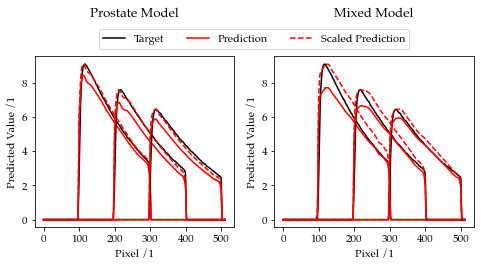

In [485]:
@latex(width=20, height=8, path="/Users/simongutwein/Desktop/scale.pdf")
def irgendwas():
    fig, ax = plt.subplots(1,2, figsize=(12,5))

    for z, pos in zip(r.iterrows(),[100,100,200,200,300,300]):
        if z[1]["model"] == "prostate":
            # peak = z[1]["z_t"].max()
            # ax[0].text(pos+70, peak-0.2, f"{pos} px.")
            fac = z[1]["z_t"].max()/z[1]["z_p"].max()
            print(z[1]["z_t"].max(), z[1]["z_p"].max(), z[1]["z_t"].max()/z[1]["z_p"].max())
            ax[0].plot(z[1]["z_t"], color="black")
            ax[0].plot(z[1]["z_p"], color="red")
            ax[0].plot(z[1]["z_p"]*fac, "--", color="red")

        if z[1]["model"] == "mixed":
            # peak = z[1]["z_t"].max()
            # ax[1].text(pos+70, peak-0.2, f"{pos} px.")
            fac = z[1]["z_t"].max()/z[1]["z_p"].max()
            print(z[1]["z_t"].max(), z[1]["z_p"].max(), z[1]["z_t"].max()/z[1]["z_p"].max())
            ax[1].plot(z[1]["z_t"], color="black")
            ax[1].plot(z[1]["z_p"], color="red")
            ax[1].plot(z[1]["z_p"]*fac, "--", color="red")

        ax[1].set_title("Mixed Model", pad=40)
        ax[1].set_xlabel("Pixel /1")
        ax[1].set_ylabel("Predicted Value /1")
        ax[1].legend(["Target", "Prediction", "Scaled Prediction"], bbox_to_anchor=[-0.1, 1.1], ncol=3, loc="center")
        ax[0].set_title("Prostate Model", pad=40)
        ax[0].set_xlabel("Pixel /1")
        ax[0].set_ylabel("Predicted Value /1")




    return fig

irgendwas()


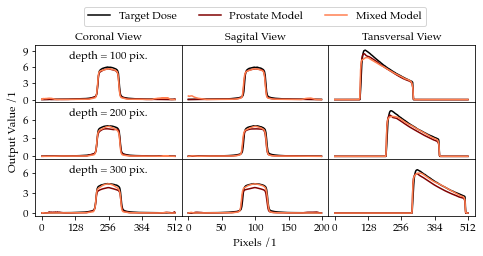

In [36]:
@latex(width=20, height=8, path="/Users/simongutwein/Desktop/quer.pdf")
def plot_2():

    pos = r["pos"].unique()
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    maxs = [10, 9, 8]

    for num ,p in enumerate(pos):
        tmp = r[r["pos"]==p]

        ax[num,0].plot(tmp.iloc[0]["x_t"], color="Black")
        ax[num,0].plot(tmp.iloc[0]["x_p"], color="Maroon")
        ax[num,0].plot(tmp.iloc[1]["x_p"], color="Coral")
        ax[num,0].set_ylim([-.5, maxs[num]])
        ax[num,0].set_xticks([0, 128, 256, 384, 512])
        ax[num, 0].axes.get_xaxis().set_visible(False)
        ax[num, 0].set_yticks(range(0, int(ax[num, 0].get_ylim()[1]),3))


        ax[num,1].plot(tmp.iloc[0]["y_t"], color="Black")
        ax[num,1].plot(tmp.iloc[0]["y_p"], color="Maroon")
        ax[num,1].plot(tmp.iloc[1]["y_p"], color="Coral")
        ax[num, 1].set_ylim([-.5, maxs[num]])
        ax[num,1].set_xticks([0,50, 100, 150 ,200])
        ax[num,1].axes.get_yaxis().set_visible(False)
        ax[num, 1].axes.get_xaxis().set_visible(False)



        ax[num,2].plot(tmp.iloc[0]["z_t"], color="Black")
        ax[num,2].plot(tmp.iloc[0]["z_p"], color="Maroon")
        ax[num,2].plot(tmp.iloc[1]["z_p"], color="Coral")
        ax[num, 2].set_ylim([-.5, maxs[num]])
        ax[num,2].set_xticks([0, 128, 256, 384, 512])
        ax[num,2].axes.get_yaxis().set_visible(False)
        ax[num, 2].axes.get_xaxis().set_visible(False)


    ax[0, 0].text(256,11.5,"Coronal View", va="center",ha="center")
    ax[0, 1].text(100, 11.5, "Sagital View", va="center", ha="center")
    ax[0, 2].text(256, 11.5, "Tansversal View", va="center", ha="center")
    ax[2, 0].axes.get_xaxis().set_visible(True)
    ax[2, 1].axes.get_xaxis().set_visible(True)
    ax[2, 2].axes.get_xaxis().set_visible(True)
    ax[2,1].set_xlabel("Pixels /1")
    ax[1,0].set_ylabel("Output Value /1")

    ax[0, 0].text(256, .8*ax[0,0].get_ylim()[1], "depth = 100 pix.", va="center", ha="center")
    ax[1, 0].text(256, .8*ax[1,0].get_ylim()[1], "depth = 200 pix.", va="center", ha="center")
    ax[2, 0].text(256, .8*ax[2,0].get_ylim()[1], "depth = 300 pix.", va="center", ha="center")


    legend = ["Target Dose", "Prostate Model", "Mixed Model"]
    ax[0,1].legend(legend, bbox_to_anchor=(0.5, 1.5), borderaxespad=0, loc="center", ncol=3)
    plt.subplots_adjust(wspace=0, hspace=0)

    return fig

plot_2()


In [446]:
def latex(width, height, path):
    '''Decorator that sets latex parameters for plt'''
    def do_latex(func):
        def wrap(*args, **kwargs):

            plt.rcParams["font.family"] = "serif"
            plt.rcParams["font.serif"] = "Palatino"
            plt.rcParams["font.size"] = 11
            fig = func(*args, **kwargs)
            cm = 1/2.54
            fig.set_size_inches(width*cm, height*cm, forward=True)
            plt.savefig(path, dpi=300, bbox_inches='tight')
        return wrap
    return do_latex


55.394833


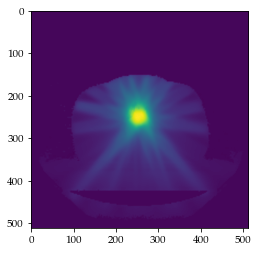

In [499]:
root_dir = "/Users/simongutwein/Desktop/prostate_dvh"
ct_file = os.path.join(root_dir, "CT_image0.dcm")
structure_file = os.path.join(root_dir, "pt3_strctr.dcm")
target_dose = np.array(torch.load(os.path.join(root_dir, "target.pt")))
prediction_dose=np.array(torch.load(os.path.join(root_dir, "prediction.pt")))

print(target_dose.max())
plt.imshow(target_dose[:,:,50])

# with dcmread(ct_file, force=True) as fin:
#     origin = np.array(fin.ImagePositionPatient).astype(float)
#     px_sp = fin.PixelSpacing
#     px_sp.append(3)
#     px_sp = np.array(px_sp).astype(float)
#     print(origin, px_sp)


In [487]:
structures = analyse_structures(structure_file, origin, px_sp, target_dose.shape, target_dose, prediction_dose)

100%|██████████| 31/31 [00:10<00:00,  3.04it/s]


In [489]:
plot_strucs = ["patient", "rectum", "ctv", "bladder", "ptv", "analcanal", "seminal", "femur"]

strucs = []
for struc in structures:
    if any(x in struc["struc_name"].lower() for x in plot_strucs):
        strucs.append(struc)

In [498]:
strucs[0]["target_dvh"]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999997744867883,
 0.9999945876829194,
 0.9999776741920425,
 0.9976614279947591,
 0.9834049337780454,
 0.9585236101056981,
 0.9252554500905436,
 0.8870674938491272,
 0.8460998617604012,
 0.8043785645182023,
 0.7656103627831037,
 0.7306014662869024,
 0.6988728849679658,
 0.6703055478505209,
 0.644442114141257,
 0.6211001436519158,
 0.600133729334533,
 0.5809867556090773,
 0.5640658227962285,
 0.5490743810226122,
 0.5356664930214937,
 0.5234964470393498,
 0.512379773269017,
 0.5021026851858116,
 0.49273373880608795,
 0.48395022472391547,
 0.4758829406020752,
 0.46813611075404854,
 0.4607440131880126,
 0.4535999801548374,
 0.4466584579857611,
 0.4401402241150298,
 0.4339122257477454,
 0.42818982800107347,
 0.42280051326806983,
 0.41764505573559024,
 0.41275277212115474,
 0.40819492459965767,
 0.40392798912124267,
 0.39985995629553955,
 0.3960320950402879,
 0.39253686577228125,
 0.38921753680939397,
 0.3859926978822054,
 0.382971722898386,
 0.38

/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_1349/3559965012.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(range(-20,101,20)))


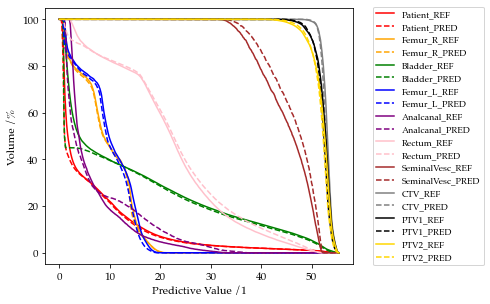

In [204]:
@latex(width=14, height=12, path="/Users/simongutwein/Desktop/dvh_notable.pdf")
def plot():
    fig, ax = plt.subplots(1, 1)

    colorList = ['red', 'orange', 'green', 'blue',
                 'purple', 'pink', 'brown', 'gray', 'black', 'gold']

    legends = ["Patient", "Femur_R", "Bladder", "Femur_L", "Analcanal", "Rectum", "SeminalVesc", "CTV", "PTV1", "PTV2"]
    cols = ("D98 Target / Pred.", "D2 Target / Pred.", "D Mean Target / Pred.", )

    legend = []
    data = []

    

    #sf = 1.1
    for num, struc in enumerate(strucs):

        d98_t = np.round(struc["target_D98"], 2)*sf
        d98_p = np.round(struc["prediction_D98"], 2)*sf

        d2_t = np.round(struc["target_D2"], 2)*sf
        d2_p = np.round(struc["prediction_D2"], 2)*sf

        dmean_t = np.round(struc["target_Dmean"], 2)*sf
        dmean_p = np.round(struc["prediction_Dmean"], 2)*sf

        #print(struc["struc_name"])
        data.append({
            "structure": struc["struc_name"],
            "D2": str(d98_t) + " / " + str(d98_p) + " / " + str(np.round((d98_p-d98_t),4)),
            "D98": str(d2_t) + " / " + str(d2_p) + " / " + str(np.round((d2_p-d2_t),4)),
            "D_mean": str(dmean_t) + " / " + str(dmean_p) + " / " + str(np.round((dmean_p-dmean_t),4))
            })

        ax.plot(struc["dvh_x"], struc["target_dvh"], color=colorList[num])
        ax.plot(struc["dvh_x"], struc["prediction_dvh"], "--", color=colorList[num])
        legend.append(legends[num] + "_REF")
        legend.append(legends[num] + "_PRED")

    # the_table = plt.table(cellText=data,
    #                         rowLabels=legends,
    #                         colLabels=cols,
    #                         loc='bottom',
    #                         colLoc="center",
    #                         bbox=(0,-0.7,1.45,0.55),
    #                         cellLoc="center",
    #                         fontsize=14)

    ax.legend(legend, bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=9)
    ax.set_ylabel("Volume /%")
    ax.set_xlabel("Predictive Value /1")
    ax.set_yticklabels(list(range(-20,101,20)))

    #print(pd.DataFrame(data))
    
    return fig



plot()


57 56 35
730.3213836669922
135.7
638.1501281738281


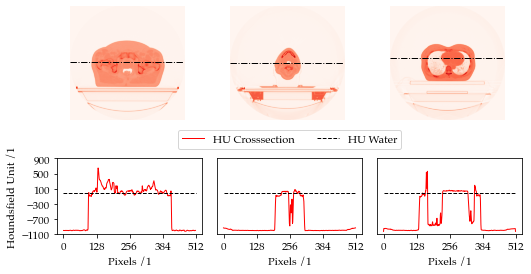

In [191]:
import torch
import numpy as np
import matplotlib.pyplot as plt

p = 250
h = 255
m = 230

dat_p = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/p35_17/training_data.pt"))[1]
t_p = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/p35_17/target_data.pt"))[0]
sz_p = dat_p.shape
x_p = []
idx_p = np.argwhere(t_p == t_p.max())[0]
for i in range(-2, 2):
    x_p.append(dat_p[p, :, idx_p[2]+i])


x_p = np.array(x_p)
x_p = x_p.mean(axis=0)

dat_h = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/ht0_0/training_data.pt"))[1]
t_h= np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/ht0_0/target_data.pt"))[0]
sz_h = dat_h.shape
x_h = []
idx_h = np.argwhere(t_h == t_h.max())[0]
idx_h[2] = idx_h[2]+10
for i in range(-2,2):
    x_h.append(dat_h[h, :, idx_h[2]+i])


x_h = np.array(x_h)
x_h = x_h.mean(axis=0)

dat_m = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/mt0_0/training_data.pt"))[1]
t_m = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/mt0_0/target_data.pt"))[0]
sz_m = dat_m.shape
x_m = []
idx_m = np.argwhere(t_m == t_m.max())[0]
for i in range(-2, 2):
    x_m.append(dat_m[m, :, idx_m[2]+i])


x_m = np.array(x_m)
x_m = x_m.mean(axis=0)


@latex(width=20, height=10, path="/Users/simongutwein/Desktop/cross.pdf")
def test():
    fig, ax = plt.subplots(2, 3, gridspec_kw={'height_ratios': [3, 2]})
    ax[0, 0].imshow(dat_p[:, :, idx_p[2]], cmap="Reds")
    ax[0, 1].imshow(dat_h[:, :, idx_h[2]], cmap="Reds")
    ax[0, 2].imshow(dat_m[:, :, idx_m[2]], cmap="Reds")

    print(idx_p[2], idx_h[2], idx_m[2])

    ax[0, 0].plot([0, 512], [p, p], "-.", linewidth=1, color="k")
    ax[0, 1].plot([0, 512], [h, h], "-.", linewidth=1, color="k")
    ax[0, 2].plot([0, 512], [m, m], "-.", linewidth=1, color="k")

    ax[1, 0].plot((x_p*1800)-1024, color="red", linewidth=1)
    ax[1, 1].plot((x_h*1800)-1024, color="red", linewidth=1)
    ax[1, 2].plot((x_m*1800)-1024, color="red", linewidth=1)
    ax[1, 0].plot([0, 512], [0, 0], "--", linewidth=1, color="k")
    ax[1, 1].plot([0, 512], [0, 0], "--", linewidth=1, color="k")
    ax[1, 2].plot([0, 512], [0, 0], "--", linewidth=1, color="k")
    ax[1, 1].legend(["HU Crosssection", "HU Water"], bbox_to_anchor=(0.5, 1.25), borderaxespad=0, loc="center", ncol=2)

    ax[0, 0].axis("off")
    ax[0, 1].axis("off")
    ax[0, 2].axis("off")

    for i in range(3):
        print(ax[1, i].get_ylim()[1])
        ax[1, i].set_yticks(np.linspace(-1100, 900, 6))
        ax[1, i].set_xticks([0, 128, 256, 384, 512])
        ax[1, i].set_xlabel("Pixels /1")
        ax[1,i].axes.get_yaxis().set_visible(False)

    ax[1, 0].axes.get_yaxis().set_visible(True)
    ax[1, 0].set_ylabel("Houndsfield Unit /1")
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.1)

    return fig

test()


In [258]:
import pandas as pd

results = "/Users/simongutwein/Desktop/segment_results.pkl"
df = pd.read_pickle(results)
df = df.replace(r'\n', ' ', regex=True)
df

df = pd.melt(df, id_vars = ["segment", "fieldsize"], value_name="gamma", var_name="model")
df.loc[df["model"].str.contains("mix"),"model"] = "Mixed"
df.loc[df["model"].str.contains("pros"), "model"] = "Prostate"

entities = ["pt", "ht", "mt", "lt", "nt"]

df_plan = pd.read_pickle("/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_case_results.pkl")

results = []
for e in entities:
    tmp_df = df.loc[df["segment"].str.contains(e)]
    tmp_df_plan = df_plan.loc[df_plan["plan"].str.contains(e)]


    pros = tmp_df.loc[tmp_df["model"].str.contains("Pros")]["gamma"].astype(float)
    mix = tmp_df.loc[tmp_df["model"].str.contains("Mix")]["gamma"].astype(float)

    pros_plan = tmp_df_plan.loc[tmp_df_plan["model"].str.contains("pros")]["gamma"].astype(float)
    mix_plan = tmp_df_plan.loc[tmp_df_plan["model"].str.contains("mix")]["gamma"].astype(float)

    results.append({
        "entity": e,
        "model": "Prostate",
        "seg_mean":   np.round(pros.mean(), 2),
        "seg_std": np.round(pros.std(), 2),
        "seg_min": np.round(pros.min(), 2),
        "seg_max": np.round(pros.max(), 2),
        "plan_mean":   np.round(pros_plan.mean(), 2),
        "plan_std": np.round(pros_plan.std(), 2),
        "plan_min": np.round(pros_plan.min(), 2),
        "plan_max": np.round(pros_plan.max(), 2),
    })

    results.append({
        "entity": e,
        "model": "Mixed",
        "seg_mean": np.round(mix.mean(), 2),
        "seg_std":  np.round(mix.std(), 2),
        "seg_min":  np.round(mix.min(), 2),
        "seg_max":  np.round(mix.max(), 2),
        "plan_mean": np.round(mix_plan.mean(), 2),
        "plan_std":  np.round(mix_plan.std(), 2),
        "plan_min":  np.round(mix_plan.min(), 2),
        "plan_max":  np.round(mix_plan.max(), 2),
    })
    

res = pd.DataFrame(results).T

res.to_excel("/Users/simongutwein/Desktop/results.xlsx")




In [300]:
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/segment_results/"
pats = [x for x in os.listdir(root) if "m" in x]
pats

from tqdm import tqdm

results = []
for pat in tqdm(pats):
    segs = [x for x in os.listdir(root + pat) if "m" in x]
    for seg in tqdm(segs):
        with open(os.path.join(root, pat, seg, "prostate_trained_UNET_2234.pt", "gamma.txt"), "r") as fin:
            lines = fin.readlines()
            results.append({
                "seg": seg,
                "model":"pros",
                "gamma": float(lines[-5].strip()),
                "fz": float(lines[-1].replace("tensor(","").replace(")\n",""))
            })

            

        with open(os.path.join(root, pat, seg, "mixed_trained_UNET_1183.pt", "gamma.txt"), "r") as fin:
            lines = fin.readlines()
            results.append({
                "seg":seg,
                "model": "mix",
                "gamma": float(lines[-5].strip()),
                "fz": float(lines[-1].replace("tensor(", "").replace(")\n", ""))
            })

100%|██████████| 5/5 [02:33<00:00, 30.74s/it]


In [301]:
import pandas as pd

df = pd.DataFrame(results)
df

,seg,model,gamma,fz
0,mt0_0,pros,81.205,79.7304
1,mt0_0,mix,79.695,79.7304
2,mt0_1,pros,78.360,70.8796
3,mt0_1,mix,77.095,70.8796
4,mt0_10,pros,82.810,16.3912
...,...,...,...,...
833,mt4_78,mix,85.070,38.2978
834,mt4_8,pros,71.120,10.3389
835,mt4_8,mix,91.235,10.3389
836,mt4_9,pros,70.170,8.4514


In [302]:
df_tmp = df.loc[df["model"].str.contains("pros")]
print(df_tmp.sort_values("gamma").iloc[:10])
bad_segments = list(df_tmp.sort_values("gamma").iloc[:10]["gamma"])
for s in bad_segments:
    print(s, end=" ")



        seg model    gamma      fz
102  mt0_55  pros   1.8935  2.3330
112   mt0_6  pros   2.3627  2.5605
342  mt2_16  pros   3.0733  5.3290
106  mt0_57  pros   3.2233  3.8893
258  mt1_58  pros   5.7650  3.4712
788  mt4_58  pros   7.3300  2.8190
824  mt4_74  pros   9.2600  2.0261
344  mt2_17  pros  14.9003  5.4375
90    mt0_5  pros  15.8100  2.8592
76   mt0_43  pros  16.9300  6.5090
1.8935 2.3627 3.0733 3.2233 5.765 7.33 9.26 14.9003 15.81 16.93 

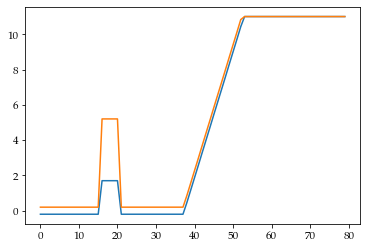

mt0_55





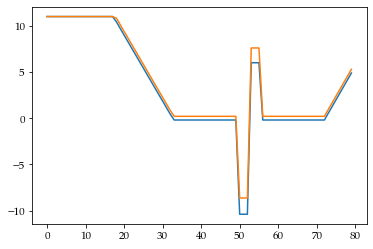

mt0_6





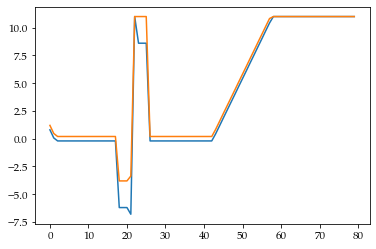

mt2_16





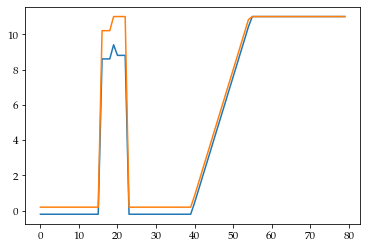

mt0_57





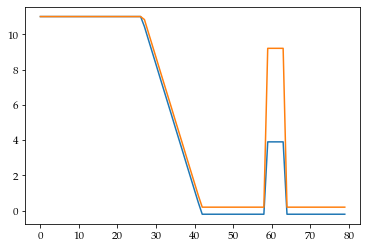

mt1_58





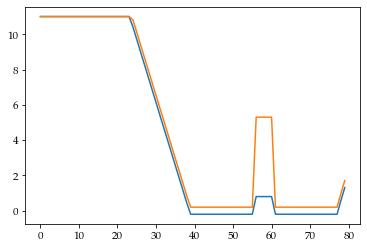

mt4_58





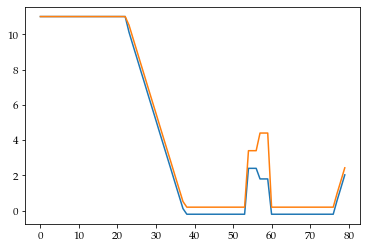

mt4_74





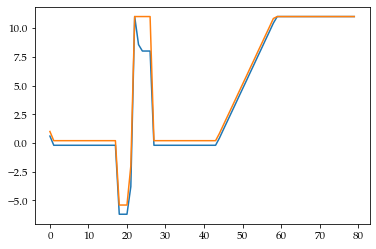

mt2_17





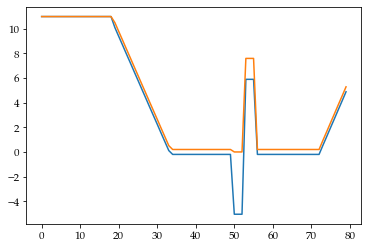

mt0_5





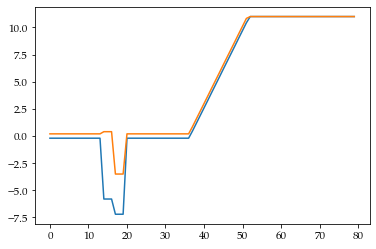

mt0_43





In [59]:
root = "/mnt/qb/baumgartner/sgutwein84/output/output_test"
root2 = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_cases"
for seg in bad_segments:
    with open(os.path.join(root, seg, f"beam_config_{seg}.txt"), "r") as fin:
        lines = fin.readlines()[:-1]
        lines = np.array([x.strip()[:-3].split(",") for x in lines]).astype(float)
        plt.plot(range(len(lines[:,0])),lines[:,0])
        plt.plot(range(len(lines[:, 1])), lines[:, 1])
        plt.show()
        print(seg+"\n\n\n")

    


In [116]:
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/output"
folder = ["output_head", "output_liver", "output_mamma", "output_prostate"]
n = ["h","l","m","p"]

from tqdm import tqdm

info = []
for a, f in zip(n, folder):
    segs = [x for x in os.listdir(os.path.join(root, f)) if not x.startswith(".") and not "ct" in x and not "egsphant" in x]
    
    for s in segs:
        print(s)
        with open(os.path.join(root, f, s, f"beam_config_{s}.txt"), "r") as fin:
            lines = fin.readlines()
            lines = np.array([x.strip()[:-3].split(",") for x in lines]).astype(float)
            idxs = 40+np.round(lines[-1]/0.7125)[0].astype(int), 40+np.round(lines[-1]/0.7125)[1].astype(int)
            lines = lines[:-1,:]
            # plt.plot(range(len(lines[idxs[0]:idxs[1], 0])), lines[idxs[0]:idxs[1], 0])
            # plt.plot(range(len(lines[idxs[0]:idxs[1], 0])), lines[idxs[0]:idxs[1], 1])
            # plt.show()
            diff = np.abs(np.sum(lines[idxs[0]:idxs[1], 0]-lines[idxs[0]:idxs[1], 1])*0.7125)
            
            info.append({
                "seg": s,
                "fz": diff
            })
            # results.append({
            #     "seg": seg,
            #     "model": "mix",
            #     "gamma": float(lines[-5].strip()),
            #     "fz": float(lines[-1].replace("tensor(", "").replace(")\n", ""))
            # })
        





h0_0
h0_1
h0_10
h0_11
h0_12
h0_13
h0_14
h0_15
h0_16
h0_17
h0_18
h0_19
h0_2
h0_20
h0_21
h0_22
h0_23
h0_24
h0_25
h0_26
h0_27
h0_28
h0_29
h0_3
h0_30
h0_31
h0_32
h0_33
h0_34
h0_35
h0_36
h0_37
h0_38
h0_39
h0_4
h0_40
h0_5
h0_6
h0_7
h0_8
h0_9
h1_0
h1_1
h1_10
h1_11
h1_12
h1_13
h1_14
h1_15
h1_16
h1_17
h1_18
h1_19
h1_2
h1_20
h1_21
h1_22
h1_23
h1_24
h1_25
h1_26
h1_27
h1_28
h1_29
h1_3
h1_30
h1_31
h1_32
h1_33
h1_34
h1_35
h1_36
h1_37
h1_38
h1_39
h1_4
h1_40
h1_41
h1_42
h1_43
h1_44
h1_45
h1_46
h1_47
h1_48
h1_49
h1_5
h1_50
h1_51
h1_52
h1_53
h1_54
h1_55
h1_56
h1_57
h1_58
h1_59
h1_6
h1_60
h1_61
h1_62
h1_7
h1_8
h1_9
h2_0
h2_1
h2_10
h2_11
h2_12
h2_13
h2_14
h2_15
h2_16
h2_17
h2_18
h2_19
h2_2
h2_20
h2_21
h2_22
h2_23
h2_24
h2_25
h2_26
h2_27
h2_28
h2_29
h2_3
h2_30
h2_31
h2_32
h2_33
h2_34
h2_35
h2_36
h2_37
h2_38
h2_39
h2_4
h2_40
h2_41
h2_42
h2_43
h2_44
h2_45
h2_46
h2_47
h2_48
h2_49
h2_5
h2_50
h2_51
h2_52
h2_53
h2_54
h2_55
h2_6
h2_7
h2_8
h2_9
h3_0
h3_1
h3_10
h3_11
h3_12
h3_13
h3_14
h3_15
h3_16
h3_17
h3_18
h3_19


In [125]:
df = pd.DataFrame(info)
df.head()

,seg,fz
0,h0_0,143.14125
1,h0_1,74.84100
2,h0_10,62.18700
3,h0_11,14.49225
4,h0_12,117.12075
5,h0_13,13.28100
6,h0_14,11.25750
7,h0_15,30.95100
8,h0_16,107.34525


In [135]:
df.to_pickle("/Users/simongutwein/Desktop/fz_analysis.pkl")

df_tmp = df.loc[df["seg"].str.contains(r'[h,p,l,m][1,2,3,4,5,6,7,8,9,10]_')]
for i in df_tmp.iterrows():
    print(i)

(0, seg         h0_0
fz     143.14125
Name: 0, dtype: object)
(1, seg      h0_1
fz     74.841
Name: 1, dtype: object)
(2, seg     h0_10
fz     62.187
Name: 2, dtype: object)
(3, seg       h0_11
fz     14.49225
Name: 3, dtype: object)
(4, seg        h0_12
fz     117.12075
Name: 4, dtype: object)
(5, seg     h0_13
fz     13.281
Name: 5, dtype: object)
(6, seg      h0_14
fz     11.2575
Name: 6, dtype: object)
(7, seg     h0_15
fz     30.951
Name: 7, dtype: object)
(8, seg        h0_16
fz     107.34525
Name: 8, dtype: object)
(9, seg     h0_17
fz     95.475
Name: 9, dtype: object)
(10, seg      h0_18
fz     50.4735
Name: 10, dtype: object)
(11, seg       h0_19
fz     17.05725
Name: 11, dtype: object)
(12, seg       h0_2
fz     6.56925
Name: 12, dtype: object)
(13, seg      h0_20
fz     141.246
Name: 13, dtype: object)
(14, seg       h0_21
fz     124.2885
Name: 14, dtype: object)
(15, seg     h0_22
fz     98.553
Name: 15, dtype: object)
(16, seg      h0_23
fz     21.2325
Name: 16, dtype: ob

238.545


<BarContainer object of 19 artists>

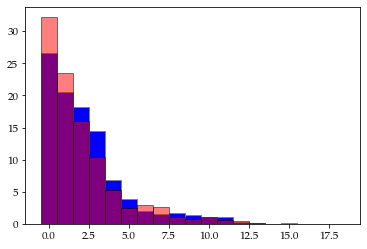

In [154]:
n=15
sizes = df_tmp["fz"]
max_s = sizes.max()
print(max_s)
max_s = (np.ceil((max_s/n)+1)*n).astype(int)
df_tmp['discrete'] = pd.cut(df_tmp["fz"], list(range(0, max_s, n)), include_lowest=True)
df_tmp["discrete"] = [int(x.right) for x in df_tmp["discrete"]]

hist = list(np.histogram(df_tmp["fz"][::2], bins=list(range(0, max_s, n)), density=True))

fig, ax = plt.subplots()
ax.bar(list(range(int(max_s/n)-1)), hist[0]*100*n, width=1, linewidth=1, edgecolor="grey", facecolor="blue", zorder=0)

results = "/Users/simongutwein/Desktop/segment_results.pkl"

df = pd.read_pickle(results)
df = pd.melt(df, id_vars=['segment', "fieldsize"], value_vars=['mixed', 'prostate'])
df["fieldsize"] = df["fieldsize"].astype(float)
df["value"] = df["value"].replace("\n", "").astype(float)

sizes = df["fieldsize"]
max_s = sizes.max()
max_s = (np.ceil((max_s/n)+1)*n).astype(int)
df['discrete'] = pd.cut(df["fieldsize"], list(range(0, max_s, n)), include_lowest=True)
df["discrete"] = [int(x.right) for x in df["discrete"]]

hist = list(np.histogram(df["fieldsize"][::2], bins=list(range(0, max_s, n)), density=True))

ax.bar(list(range(int(max_s/n)-1)), hist[0]*100*n, width=1, linewidth=1, edgecolor="black", facecolor="red", zorder=0, alpha=0.5)


In [173]:
strings = ["tensor(38.5729)\n", "tensor(145.29)\n"]

import re

for string in strings:
    print(string)
    x = np.array(re.findall(r"\d*\.\d*", string)).astype(float)
    print(x)


tensor(38.5729)

[38.5729]
tensor(145.29)

[145.29]


In [213]:
print(-np.array([94.35-93.47, 75.4 - 89.8, 57.82-76.93,  60.48-80.13, 77.42-85.17]).round(2)) #segment mean
print(-np.array([96.16 - 97.85, 77.69 - 97.59, 63.25 - 87.46, 76.19 - 90.68, 82.12-90.71]).round(2))  # plan mean



[-0.88 14.4  19.11 19.65  7.75]
[ 1.69 19.9  24.21 14.49  8.59]


Plan has 40 segments.
Plan has 91 segments.
Plan has 68 segments.
Plan has 99 segments.
Plan has 81 segments.
Plan has 57 segments.
Plan has 46 segments.
Plan has 58 segments.
Plan has 55 segments.
Plan has 56 segments.
Plan has 75 segments.
Plan has 77 segments.
Plan has 111 segments.
Plan has 77 segments.
Plan has 79 segments.
Plan has 28 segments.
Plan has 32 segments.
Plan has 30 segments.
Plan has 19 segments.
Plan has 49 segments.
Plan has 60 segments.
Plan has 19 segments.
Plan has 72 segments.
Plan has 67 segments.
Plan has 34 segments.
Plan has 51 segments.
Plan has 52 segments.
Plan has 59 segments.
Plan has 30 segments.
Plan has 57 segments.
Plan has 62 segments.
Plan has 62 segments.
Plan has 52 segments.
Plan has 68 segments.
Plan has 62 segments.


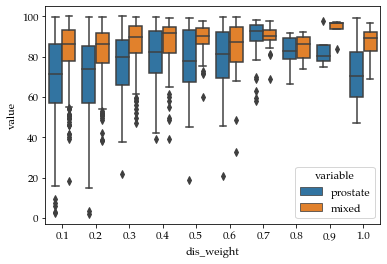

In [288]:
from pydicom import dcmread
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_cases"
plans = [x for x in os.listdir(root) if not x.startswith(".")]

weights = []
for plan in plans:

    pf = os.path.join(root, plan, [x for x in os.listdir(os.path.join(root, plan)) if not x.startswith(".") and "plan" in x][0])

    dicom_file = dcmread(pf, force=True)

    meterset_weights = []
    for beam in dicom_file.BeamSequence:
        for control_point in beam.ControlPointSequence:
            meterset_weights.append(float(control_point.CumulativeMetersetWeight))

    segment_weights = [meterset_weights[i] - meterset_weights[i-1] for i in range(1, len(meterset_weights), 2)]
    print(f"Plan has {len(segment_weights)} segments.")
    segment_names = [f"{plan}_{x}" for x in range(len(segment_weights))]

    weights.extend(zip(segment_weights, segment_names))

df_weight = pd.DataFrame(weights)
import seaborn as sb

results = "/Users/simongutwein/Desktop/segment_results.pkl"

df_fz = pd.read_pickle(results)

new_df = pd.merge(df_weight, df_fz, left_on=1, right_on="segment")
new_df = new_df.drop(columns=1)
new_df = new_df.rename(columns={0: 'weight'})
new_df["fieldsize"] = new_df["fieldsize"].astype(float)
new_df["mixed"] = new_df["mixed"].replace("\n", "").astype(float)
new_df["prostate"] = new_df["prostate"].replace("\n", "").astype(float)

bins = [(np.round(x,2), np.round(x+0.1,2)) for x in np.linspace(0,1,11)][:-1]

bins = pd.IntervalIndex.from_tuples(bins)
new_df["dis_weight"] = pd.cut(new_df["weight"], bins)
new_df["dis_weight"] = [float(x.right) for x in new_df["dis_weight"]]
new_df = pd.melt(new_df,id_vars=["weight", "segment", "fieldsize", "dis_weight"], value_vars=["prostate", "mixed"])

fig, ax = plt.subplots()
ax2 = sb.boxplot(x="dis_weight", y="value", hue="variable", data=new_df)



In [293]:
from pydicom import dcmread
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_cases"
plans = [x for x in os.listdir(root) if not x.startswith(".")]

weights = []
modu = []
for plan in plans:

    pf = os.path.join(root, plan, [x for x in os.listdir(os.path.join(root, plan)) if not x.startswith(".") and "plan" in x][0])

    dicom_file = dcmread(pf, force=True)

    meterset_weights = []
    for beam in dicom_file.BeamSequence:
        for control_point in beam.ControlPointSequence:
            meterset_weights.append(float(control_point.CumulativeMetersetWeight))

    segment_weights = [meterset_weights[i] - meterset_weights[i-1] for i in range(1, len(meterset_weights), 2)]
    #print(f"Plan has {len(segment_weights)} segments.")
    segment_names = [f"{plan}_{x}" for x in range(len(segment_weights))]

    weights.extend(zip(segment_weights, segment_names))

    modu.append({
        "plan": plan,
        "mod": len(segment_weights)
    })

df_weight = pd.DataFrame(weights)
df_modu = pd.DataFrame(modu)


,plan,mod
0,ht0,40
1,ht1,91
2,ht2,68
3,ht3,99
4,ht4,81
5,lt0,57
6,lt1,46
7,lt2,58
8,lt3,55
9,lt4,56


In [297]:
for name in ["pt", "ht", "mt", "lt"]:
    print(name, df_modu[df_modu["plan"].str.contains(name)]["mod"].mean(), df_modu[df_modu["plan"].str.contains(name)]["mod"].std())



pt 61.2 5.761944116355173
ht 75.8 23.12358103754693
mt 83.8 15.27088733505686
lt 54.4 4.827007354458868


In [303]:
root = "/Users/simongutwein/Studium/Masterarbeit/mamma"
plans = [x for x in os.listdir(root) if not x.startswith(".")]
plans

['mt0_6', 'mt0_55', 'mt2_16']

(512, 512, 109)
2.3627
[195 314  80]
(512, 512, 109)
1.8935
[210 367  36]
(512, 512, 115)
3.0733
[177 216  14]


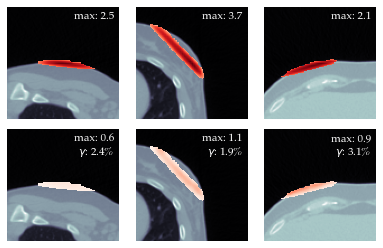

In [365]:
@latex(width=14, height=9, path="/Users/simongutwein/Desktop/mamma.pdf")
def test():

    fig, ax = plt.subplots(2,3)
    for num, plan in enumerate(plans):

        ct = np.array(torch.load(os.path.join(root, plan, "training_data.pt")))[1]
        print(ct.shape)
        path = os.path.join(root, plan, "prostate_trained_UNET_2234.pt")
        gamma = float(open(os.path.join(path, "gamma.txt")).readlines()[-5].strip())
        print(gamma)
        pred = np.array(torch.load(os.path.join(path, "prediction.pt")))
        target = np.array(torch.load(os.path.join(path, "target.pt")))

        idx = np.argwhere(target==target.max())[0]
        print(idx)

        pred[target < 1] = np.nan
        target[target < 1] = np.nan

        ax[0, num].imshow(ct[idx[0]-50:idx[0]+50, idx[1]-50:idx[1]+50, idx[2]], cmap="bone")
        ax[1, num].imshow(ct[idx[0]-50:idx[0]+50, idx[1]-50:idx[1]+50, idx[2]], cmap="bone")
        ax[0, num].imshow(target[idx[0]-50:idx[0]+50,idx[1]-50:idx[1]+50,idx[2]],vmin=0, vmax=np.nanmax(target),cmap="Reds")
        ax[1, num].imshow(pred[idx[0]-50:idx[0]+50, idx[1]-50:idx[1]+50, idx[2]], vmin=0, vmax=np.nanmax(target), cmap="Reds")
        
        t_max = str(np.round(np.nanmax(target), 1))
        p_max = str(np.round(np.nanmax(pred), 1))
        p_gamma = str(np.round(gamma, 1))

        ax[0, num].text(95, 10, f"max: {t_max}", ha="right", color="white")
        ax[1, num].text(95, 10, f"max: {p_max}", ha="right", color="white")
        ax[1, num].text(95, 22, r'$\gamma$: '+f"{p_gamma}%", ha="right", color="white")
        ax[0, num].axis("off")
        ax[1, num].axis("off")


    plt.tight_layout()
    return fig
test()


In [366]:
df = pd.read_pickle("/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/test_case_results.pkl")


In [372]:
df = df[df.model.str.contains("mixed")]
df

,plan,model,gamma,modulated,test_modularity
0,ht0,mixed_trained_UNET_1183.pt,96.2638,40,Mixed (2)
2,ht1,mixed_trained_UNET_1183.pt,92.7390,91,Mixed (2)
4,ht2,mixed_trained_UNET_1183.pt,79.6340,68,Mixed (2)
6,ht3,mixed_trained_UNET_1183.pt,92.9420,99,Mixed (2)
8,ht4,mixed_trained_UNET_1183.pt,91.8420,81,Mixed (2)
10,lt0,mixed_trained_UNET_1183.pt,89.5087,57,Mixed (2)
12,lt1,mixed_trained_UNET_1183.pt,100.0000,46,Mixed (2)
14,lt2,mixed_trained_UNET_1183.pt,98.5320,58,Mixed (2)
16,lt3,mixed_trained_UNET_1183.pt,99.9190,55,Mixed (2)
18,lt4,mixed_trained_UNET_1183.pt,99.9689,56,Mixed (2)


In [380]:
print(df[df.plan.str.contains("m")].modulated.mean(), "±", df[df.plan.str.contains("m")].modulated.std())


83.8 ± 15.27088733505686


In [385]:
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/training/training_mamma"
plans = pd.DataFrame({"seg":[x for x in os.listdir(root) if not x.startswith(".")]})


In [386]:
plans

,seg
0,m0_0
1,m0_1
2,m0_10
3,m0_11
4,m0_12
...,...
232,m9_5
233,m9_6
234,m9_7
235,m9_8


In [389]:
num = []
for i in range(10):
    num.append(len(plans[plans.seg.str.contains(f"m{i}")]))



In [391]:
num = np.array(num)

In [394]:
print(num.mean(), "±", num.std())

23.7 ± 5.568662316930341


In [ ]:
83.8 ± 15.27088733505686
23.7 ± 5.568662316930341


In [568]:
from tqdm import tqdm
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/plan_predictions_load/"
files = [x for x in os.listdir(root) if not x.startswith(".")]

dat = []
for file in tqdm(files):
    mix_new = root + file + "/mixed_trained_UNET_1183.pt/gamma.txt"
    pros_new = root + file + "/prostate_trained_UNET_2234.pt/gamma.txt"
    dat.append({
        "test_case":file,
        "mixed_gamma": float(open(mix_new).readlines()[4].strip()),
        "prostate_gamma": float(open(pros_new).readlines()[4].strip())
    })
    
print(dat)


100%|██████████| 35/35 [00:17<00:00,  1.97it/s]

[{'test_case': 'ht0', 'mixed_gamma': 98.5, 'prostate_gamma': 90.24}, {'test_case': 'ht1', 'mixed_gamma': 93.205, 'prostate_gamma': 78.84}, {'test_case': 'ht2', 'mixed_gamma': 75.97, 'prostate_gamma': 62.48}, {'test_case': 'ht3', 'mixed_gamma': 90.94, 'prostate_gamma': 81.565}, {'test_case': 'ht4', 'mixed_gamma': 85.35, 'prostate_gamma': 73.965}, {'test_case': 'lt0', 'mixed_gamma': 97.42, 'prostate_gamma': 87.39}, {'test_case': 'lt1', 'mixed_gamma': 99.22, 'prostate_gamma': 94.395}, {'test_case': 'lt2', 'mixed_gamma': 97.98, 'prostate_gamma': 91.8}, {'test_case': 'lt3', 'mixed_gamma': 96.55, 'prostate_gamma': 83.97}, {'test_case': 'lt4', 'mixed_gamma': 96.95, 'prostate_gamma': 91.755}, {'test_case': 'mt0', 'mixed_gamma': 83.675, 'prostate_gamma': 72.95}, {'test_case': 'mt1', 'mixed_gamma': 77.03, 'prostate_gamma': 60.55}, {'test_case': 'mt2', 'mixed_gamma': 84.71, 'prostate_gamma': 66.21}, {'test_case': 'mt3', 'mixed_gamma': 89.785, 'prostate_gamma': 72.58}, {'test_case': 'mt4', 'mixed_

In [573]:
df = pd.DataFrame(dat)
df['test_case'] = df['test_case'].str.replace('\d+', '')
df


/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_1349/780464707.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['test_case'] = df['test_case'].str.replace('\d+', '')


,test_case,mixed_gamma,prostate_gamma
0,ht,98.500,90.240
1,ht,93.205,78.840
2,ht,75.970,62.480
3,ht,90.940,81.565
4,ht,85.350,73.965
5,lt,97.420,87.390
6,lt,99.220,94.395
7,lt,97.980,91.800
8,lt,96.550,83.970
9,lt,96.950,91.755


In [574]:
ent = ["pt", "ht", "lt", "mt", "nt"]
test = ["Prostate", "Mixed", "Mixed", "Mixed", "Lymphnodes"]
long = ["Prostate", "H&N", "Liver", "Mamma", "Lymphnodes"]
df_ent = pd.DataFrame({"entity": ent, "test": test, "long":long})

df['test_case'] = df['test_case'].map(df_ent.set_index('entity')['long'])
df


,test_case,mixed_gamma,prostate_gamma
0,H&N,98.500,90.240
1,H&N,93.205,78.840
2,H&N,75.970,62.480
3,H&N,90.940,81.565
4,H&N,85.350,73.965
5,Liver,97.420,87.390
6,Liver,99.220,94.395
7,Liver,97.980,91.800
8,Liver,96.550,83.970
9,Liver,96.950,91.755


In [575]:
df['test_mode'] = None
df['test_mode'] = df['test_case'].map(df_ent.set_index('long')['test'])
df


,test_case,mixed_gamma,prostate_gamma,test_mode
0,H&N,98.500,90.240,Mixed
1,H&N,93.205,78.840,Mixed
2,H&N,75.970,62.480,Mixed
3,H&N,90.940,81.565,Mixed
4,H&N,85.350,73.965,Mixed
5,Liver,97.420,87.390,Mixed
6,Liver,99.220,94.395,Mixed
7,Liver,97.980,91.800,Mixed
8,Liver,96.550,83.970,Mixed
9,Liver,96.950,91.755,Mixed


In [576]:
res = []
for t in long:
    mini = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].min(),1)
    maxi = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].max(),1)
    mean = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].mean(),1)
    std = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].std(),1)
    median = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].median(),1)
    mini2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].min(), 1)
    maxi2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].max(), 1)
    mean2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].mean(), 1)
    std2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].std(), 1)
    median2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].median(), 1)
    res.append({
        "test": t,
        "Model": "Prostate",
        "Mean": mean2,
        "Median": median2,
        "STD": std2,
        "Min": mini2,
        "Max": maxi2
    })
    res.append({
        "test": t,
        "Model": "Mixed",
        "Mean":mean,
        "Median":median,
        "STD": std,
        "Min":mini, 
        "Max": maxi
    })

df_res = pd.DataFrame(res)
df_res = df_res.T
df_res = df_res[[0, 1, 4, 5, 6, 7, 2, 3, 8, 9]]
df_res


,0,1,4,5,6,7,2,3,8,9
test,Prostate,Prostate,Liver,Liver,Mamma,Mamma,H&N,H&N,Lymphnodes,Lymphnodes
Model,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed
Mean,99.1,99.2,89.9,97.6,67.4,83.6,77.4,88.8,93.0,96.0
Median,99.6,99.7,91.8,97.4,66.2,83.7,78.8,90.9,92.8,98.8
STD,1.3,1.0,4.1,1.0,5.3,4.6,10.2,8.6,6.1,5.8
Min,96.8,97.5,84.0,96.6,60.6,77.0,62.5,76.0,75.3,77.9
Max,99.9,99.9,94.4,99.2,73.0,89.8,90.2,98.5,99.7,99.9


In [558]:
from tqdm import tqdm
root = "/Users/simongutwein/mnt/qb/baumgartner/sgutwein84/segment_results/"
files = [x for x in os.listdir(root) if not x.startswith(".")]

dat = []
for num, file in enumerate(files):
    print(num)
    segs = [x for x in os.listdir(root + file) if not x.startswith(".")]
    for seg in tqdm(segs):
        mix_new = root + file + "/" + seg + "/mixed_trained_UNET_1183.pt/gamma.txt"
        pros_new = root + file + "/" + seg + "/prostate_trained_UNET_2234.pt/gamma.txt"
        dat.append({
        "test_case": file,
        "mixed_gamma": float(open(mix_new).readlines()[4].strip()),
        "prostate_gamma": float(open(pros_new).readlines()[4].strip())
        })

print(dat)


0


100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


1


100%|██████████| 91/91 [01:58<00:00,  1.30s/it]


2


100%|██████████| 68/68 [01:31<00:00,  1.35s/it]


3


100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


4


100%|██████████| 81/81 [01:15<00:00,  1.08it/s]


5


100%|██████████| 57/57 [01:00<00:00,  1.07s/it]


6


100%|██████████| 46/46 [00:48<00:00,  1.05s/it]


7


100%|██████████| 58/58 [00:46<00:00,  1.24it/s]


8


100%|██████████| 55/55 [00:36<00:00,  1.49it/s]


9


100%|██████████| 56/56 [00:37<00:00,  1.51it/s]


10


100%|██████████| 75/75 [00:56<00:00,  1.33it/s]


11


100%|██████████| 77/77 [00:44<00:00,  1.72it/s]


12


100%|██████████| 111/111 [01:14<00:00,  1.49it/s]


13


100%|██████████| 77/77 [00:51<00:00,  1.49it/s]


14


100%|██████████| 79/79 [00:55<00:00,  1.43it/s]


15


100%|██████████| 28/28 [00:15<00:00,  1.75it/s]


16


100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


17


  0%|          | 0/19 [00:00<?, ?it/s]

18


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


19


100%|██████████| 49/49 [00:30<00:00,  1.58it/s]


20


100%|██████████| 60/60 [00:34<00:00,  1.74it/s]


21


100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


22


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


23


100%|██████████| 67/67 [00:50<00:00,  1.33it/s]


24


100%|██████████| 34/34 [00:19<00:00,  1.76it/s]


25


100%|██████████| 51/51 [00:33<00:00,  1.51it/s]


26


100%|██████████| 52/52 [00:31<00:00,  1.67it/s]


27


100%|██████████| 59/59 [00:31<00:00,  1.86it/s]


28


100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


29


100%|██████████| 57/57 [00:41<00:00,  1.38it/s]


30


100%|██████████| 62/62 [00:46<00:00,  1.32it/s]


31


100%|██████████| 62/62 [00:41<00:00,  1.50it/s]


32


  0%|          | 0/68 [00:00<?, ?it/s]

33


100%|██████████| 68/68 [00:46<00:00,  1.45it/s]


34


100%|██████████| 62/62 [00:42<00:00,  1.44it/s]

[{'test_case': 'ht0', 'mixed_gamma': 84.875, 'prostate_gamma': 73.415}, {'test_case': 'ht0', 'mixed_gamma': 78.485, 'prostate_gamma': 70.785}, {'test_case': 'ht0', 'mixed_gamma': 84.755, 'prostate_gamma': 80.485}, {'test_case': 'ht0', 'mixed_gamma': 88.795, 'prostate_gamma': 82.55}, {'test_case': 'ht0', 'mixed_gamma': 89.39, 'prostate_gamma': 65.77}, {'test_case': 'ht0', 'mixed_gamma': 92.1, 'prostate_gamma': 62.815}, {'test_case': 'ht0', 'mixed_gamma': 95.77, 'prostate_gamma': 68.63}, {'test_case': 'ht0', 'mixed_gamma': 93.31, 'prostate_gamma': 86.5}, {'test_case': 'ht0', 'mixed_gamma': 94.84, 'prostate_gamma': 86.05}, {'test_case': 'ht0', 'mixed_gamma': 96.73, 'prostate_gamma': 91.485}, {'test_case': 'ht0', 'mixed_gamma': 91.74, 'prostate_gamma': 56.515}, {'test_case': 'ht0', 'mixed_gamma': 91.52, 'prostate_gamma': 73.745}, {'test_case': 'ht0', 'mixed_gamma': 87.04, 'prostate_gamma': 79.965}, {'test_case': 'ht0', 'mixed_gamma': 92.685, 'prostate_gamma': 78.63}, {'test_case': 'ht0', '

In [565]:
df = pd.DataFrame(dat)
df['test_case'] = df['test_case'].str.replace('\d+', '')
ent = ["pt", "ht", "lt", "mt", "nt"]
test = ["Prostate", "Mixed", "Mixed", "Mixed", "Lymphnodes"]
long = ["Prostate", "H&N", "Liver", "Mamma", "Lymphnodes"]
df_ent = pd.DataFrame({"entity": ent, "test": test, "long": long})

df['test_case'] = df['test_case'].map(df_ent.set_index('entity')['long'])
df['test_mode'] = None
df['test_mode'] = df['test_case'].map(df_ent.set_index('long')['test'])

res = []
for t in long:
    mini = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].min(), 1)
    maxi = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].max(), 1)
    mean = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].mean(), 1)
    std = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].std(), 1)
    median = np.round(df[df["test_case"].str.contains(t)]["mixed_gamma"].median(), 1)
    mini2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].min(), 1)
    maxi2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].max(), 1)
    mean2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].mean(), 1)
    std2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].std(), 1)
    median2 = np.round(df[df["test_case"].str.contains(t)]["prostate_gamma"].median(), 1)
    res.append({
        "test": t,
        "Model": "Prostate",
        "Mean": mean2,
        "Median": median2,
        "STD": std2,
        "Min": mini2,
        "Max": maxi2
    })
    res.append({
        "test": t,
        "Model": "Mixed",
        "Mean": mean,
        "Median": median,
        "STD": std,
        "Min": mini,
        "Max": maxi
    })

df_res = pd.DataFrame(res)
df_res = df_res.T
df_res = df_res[[0, 1, 4, 5, 6, 7, 2,3,8,9]]
df_res


/var/folders/mb/3n21yy1n3c733_bvg_x9b2_m0000gn/T/ipykernel_1349/1290184849.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['test_case'] = df['test_case'].str.replace('\d+', '')


,0,1,4,5,6,7,2,3,8,9
test,Prostate,Prostate,Liver,Liver,Mamma,Mamma,H&N,H&N,Lymphnodes,Lymphnodes
Model,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed,Prostate,Mixed
Mean,94.3,93.5,75.4,89.8,57.8,76.9,60.5,80.1,77.4,85.2
Median,96.2,95.0,77.4,91.6,56.4,78.9,61.0,82.8,80.2,87.8
STD,6.0,6.3,12.6,7.0,18.0,12.8,11.8,10.9,13.8,10.7
Min,58.0,39.2,38.9,50.8,1.9,18.4,31.1,49.3,36.0,38.7
Max,100.0,99.8,99.4,99.1,94.7,98.5,91.5,97.4,99.7,99.9


In [577]:
patient = "pt0"

root_dir = "/Users/simongutwein/Studium/Masterarbeit/plan_predictions_test/" + patient

target_dose = np.array(torch.load(os.path.join(root_dir, f"{patient}_target.pt")))
    
print(target_dose.shape)

ct_file = os.path.join(root_dir, "cts/CT_image0.dcm")

with dcmread(ct_file, force=True) as fin:
    origin = np.array(fin.ImagePositionPatient).astype(float)
    px_sp = fin.PixelSpacing
    px_sp.append(3)
    px_sp = np.array(px_sp).astype(float)
    print(origin, px_sp)

structure_file = os.path.join(root_dir, f"{patient}_strctr.dcm")
        

(512, 512, 125)
[-300.  -267.8 -390.9] [1.171875 1.171875 3.      ]


In [581]:
from itertools import zip_longest
def read_structures(strucure_file_path: str, image_origin: list, px_sp: list) -> dict:

    image_origin = np.array(image_origin)
    px_sp = np.array(px_sp)

    structures = []
    structures_data = []
    with dcmread(strucure_file_path, force=True) as dcm_in:
        for struc in dcm_in.StructureSetROISequence:
            structures.append({
                "struc_name": struc.ROIName,
                "struc_number": struc.ROINumber
            })

        for struc in dcm_in.ROIContourSequence:
            contour_data = []
            for data in struc.ContourSequence:
                contour_data.append(((np.array(data.ContourData).reshape((-1, 3))-image_origin)/px_sp).astype(int))
            structures_data.append({
                "struc_number": struc.ReferencedROINumber,
                "contour_data": contour_data
            })

    struc_data = [{**u, **v} for u, v in zip_longest(structures, structures_data, fillvalue={})]
    return struc_data


In [582]:
strucs = read_structures(structure_file, origin, px_sp)

In [611]:
def create_binary(structure_data: dict, volume_shape: list) -> dict:

    for struc in structure_data:
        if not "z" in struc["struc_name"].lower():
            binary = np.zeros(volume_shape)
            for slice_ in struc["contour_data"]:
                poly = slice_[:, :2]
                img = binary[:, :, slice_[0, 2]].copy()
                #binary[:, :, slice_[0, 2]] = cv2.fillPoly(img=img, pts=np.int32([poly]), color=1)
                binary[:, :, slice_[0, 2]] = cv2.drawContours(img, np.int32([poly]), -1, color=1, thickness=cv2.FILLED)
            struc["binary_mask"] = binary.astype(bool)
            print(binary.shape)

    return structure_data


In [689]:
import cv2
strucs = create_binary(strucs, target_dose.shape)


(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)
(512, 512, 125)


In [690]:
df = pd.DataFrame(strucs)

In [772]:
needed = ["patient", "Bladder", "Femur_R",  "Rectum","Femur_L" ,"PTV"]

n_df = df[df['struc_name'].isin(needed)]
n_df.struc_name
print(n_df.keys())

Index(['struc_name', 'struc_number', 'contour_data', 'binary_mask'], dtype='object')


(512, 512, 125)
(512, 512, 125)
185 365
96 399
1.6094445


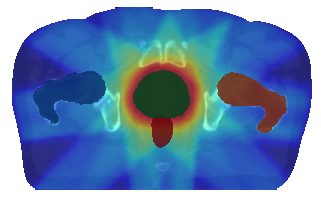

In [792]:
@latex(width=14, height=9, path="/Users/simongutwein/Desktop/example_image.pdf")
def func():
    import torch
    layer = 50
    mask = n_df[n_df["struc_name"] == "patient"]["binary_mask"][0]
    print(mask.shape)

    begin = False
    end = False
    for n, i in enumerate(mask[:,:,layer]):
        if np.any(i) and begin is False:
            begin = n
        elif not np.any(i) and begin is not False and end is False:
            end = n

    begin2 = False
    end2 = False
    tmp = np.moveaxis(mask, 0,1)
    print(tmp.shape)
    for n, i in enumerate(tmp[:, :, layer]):
        if np.any(i) and begin2 is False:
            begin2 = n
        elif not np.any(i) and begin2 is not False and end2 is False:
            end2 = n


    begin2 = begin2 -5

    end2 = end2 +5
    print(begin, end)
    print(begin2, end2)

    ct = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/training_data.pt"))[1]
    print(ct.max())
    target = np.array(torch.load("/Users/simongutwein/Studium/Masterarbeit/target.pt"))
    target[ct < .15] = np.nan
    ct[ct<.15] = np.nan


    plt.imshow(ct[begin:end,begin2:end2,layer], cmap="bone")
    plt.imshow(target[begin:end, begin2:end2, layer], cmap="jet", alpha=.5)
    cmaps = ['Greys', 'Purples', 'Blues', 'Reds', 'Oranges','Greens']
    for num ,struc in enumerate(n_df.iterrows()):
        if not struc[1]["struc_name"] == "patient":
            mask2 = struc[1]["binary_mask"].astype(float)
            mask2[mask2<0.9] = np.nan
            plt.imshow(mask2[begin:end, begin2:end2, layer], vmin=0, vmax=1, cmap=cmaps[num], alpha=0.8)
            
    plt.axis("off")
    return plt.gcf()

func()
